In [34]:
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

route_name = "hatoma_route"
dep = "hatoma_dep"
days_ago = 0
#taketomi_route isigaki_dep 1
def df_load(route_name,dep,days_ago):
    """
    学習するためのdfを作成する。
    前処理が終わった後のdf
    parameters
    ----------
    days_ago:str
        教師ラベルと説明変数を何日ずらしているか
        
    return
    ------
    X:dataframe
       説明変数のdf
    y:dataframe
       目的変数(教師ラベル)のdf 
    """
    #'../data/df_com_all_2/'+route_name+'_'+i+'_'+str(days_ago)+'.csv'
    df = pd.read_csv('../data/df_com_all_4/'+route_name+'_'+dep+'_'+str(days_ago)+'.csv', header=None)

    df = df.dropna(subset=[1])

    #データのロード
    X = df.iloc[:,3:12].values
    #print(X)
    y = df.loc[:, 1]#.values
    #print(y)
    df=df.iloc[:,3:12]
    return X,y,df
X,y,df = df_load(route_name,dep,days_ago)

In [2]:
#データの分割（テスト用とトレーニング用）
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)
print('Labels counts in y[0 1]:', np.bincount(y))
print('Labels counts in y_train[0 1]:', np.bincount(y_train))
print('Labels counts in y_test[0 1]:', np.bincount(y_test))

Labels counts in y[0 1]: [96 90]
Labels counts in y_train[0 1]: [76 72]
Labels counts in y_test[0 1]: [20 18]


In [3]:
print(y)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
185    0.0
186    0.0
187    0.0
188    0.0
190    0.0
Name: 1, Length: 186, dtype: float64


In [4]:
#標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print(X_train_std)

[[ 0.81096299 -0.50022028 -1.30530467 ...  0.19454568 -0.71257591
   0.97349039]
 [-0.96058715 -0.03012679 -1.0285352  ... -1.02033874  0.46852896
  -0.96142233]
 [-1.40347469  0.92430544 -1.58207414 ... -1.38480406 -0.007723
  -1.11026177]
 ...
 [ 0.58951922 -0.52871079 -1.0285352  ... -0.41289653 -0.46492489
   0.37813263]
 [ 0.58951922 -0.68540862  0.35531216 ...  0.55901101 -0.2744241
   0.67581151]
 [ 0.36807545  4.24345035 -0.75176573 ... -0.16991964 -0.75067607
   0.52697207]]


In [5]:
import lightgbm as lgb
def train_data(X_train, y_train,lgb):
    """学習用データの作成
        Args:
            X_train:
                学習用のトレーニングデータ
            y_train:
                学習用のラベルデータ

        Returns:
            lgb.Dataset(X_train, label=y_train):
                学習用データの作成
    """
    return lgb.Dataset(X_train, label=y_train)

train_data=train_data(X_train, y_train,lgb)

In [6]:
# テストデータの作成    
def test_data(X_test, y_test, train_data,lgb):
    """テストデータの作成
        Args:
            X_test:
                学習用のtestデータ
            y_test:
                学習用のtestデータ

        Returns:
            lgb.Dataset(X_test, label=y_test, reference=train_data):
                学習用データの作成
    """
    return lgb.Dataset(X_test, label=y_test, reference=train_data)
test_data = test_data(X_test, y_test, train_data,lgb)

In [7]:
def par():
    """
    パラメータの辞書を返す
    """
    boostring='dart'
    learning_rate=0.05
    min_data_in_leaf=20
    #applications='binary'
    feature_fraction=0.7
    num_leaves=41
    metric='auc'#'binary_logloss'#'auc'
    drop_date=0.15
    objective = "binary"
    #application = applications
    parameters = {
                'boosting': boostring,          # dart (drop out trees) often performs better
                'objective': objective,
                #'application': applications,     # Binary classification
                'learning_rate': learning_rate,       # Learning rate, controls size of a gradient descent step
                'min_data_in_leaf': min_data_in_leaf,      # Data set is quite small so reduce this a bit
                'feature_fraction': feature_fraction,     # Proportion of features in each boost, controls overfitting
                'num_leaves': num_leaves,            # Controls size of tree since LGBM uses leaf wise splits
                'metric': metric,  # Area under ROC curve as the evaulation metric
                'drop_rate': drop_date   
            }
    return parameters
parameters = par()

In [8]:
def fit(train_data, test_data, parameters, batch=100):
    """学習を行う
        Args:
            train_data:
                学習用trainデータ
            test_data:
                学習用testデータ
            batch:
                学習回数
                初期値は100
    """
    evaluation_results = {}
    model=lgb.train(parameters,
                    train_data,
                    valid_sets=[train_data, test_data], 
                    valid_names=['Train', 'Test'],
                    evals_result = evaluation_results,
                    num_boost_round=batch,
                    early_stopping_rounds=50,
                    verbose_eval=20)
    return model,evaluation_results
    #optimum_boost_rounds = self.model.best_iteration
model,evaluation_results = fit(train_data, test_data, parameters, batch=100)

[LightGBM] [Info] Number of positive: 72, number of negative: 76
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486486 -> initscore=-0.054067
[LightGBM] [Info] Start training from score -0.054067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [9]:
def predict(model,X_test):
    """予測を行う
        Args:
            X_test:
                予測をしたいデータ
        Returns:
            model.predict(X_test):
                予測結果
    """
    return model.predict(X_test)
y_pred_proba = predict(model,X_test)
#print(y_pred_proba)
y_pred = [0 if i < 0.5 else 1 for i in y_pred_proba]
print(y_pred)
y_train_proba = predict(model,X_train)
y_pred_train = [0 if i < 0.5 else 1 for i in y_train_proba]

[1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

def accuracy_rate(y_test,y_pred):
    """予測結果から正解率を表示
        Args:
            y_test:
                予測に使用したデータのラベル(目的変数)
            y_pred:
                予測結果
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC",auc)

y_pred = pd.Series(y_pred)
#print(y_test,y_pred)
#print(y_test)
#print(y_pred_proba)
accuracy_rate(y_test,y_pred_proba)
accuracy_rate(y_test,y_pred)
accuracy_rate(y_train,y_pred_train)
#print('Test Accuracy: %.3f' % model.score(X_test, y_test))
print(accuracy_score(y_test, y_pred))
print(y_pred)

AUC 0.9777777777777777
AUC 0.8638888888888888
AUC 0.924342105263158
0.868421052631579
0     1
1     1
2     1
3     0
4     0
5     0
6     1
7     0
8     1
9     0
10    1
11    1
12    0
13    0
14    1
15    1
16    0
17    1
18    0
19    0
20    0
21    0
22    0
23    0
24    1
25    0
26    0
27    0
28    1
29    0
30    0
31    0
32    0
33    1
34    0
35    1
36    0
37    1
dtype: int64


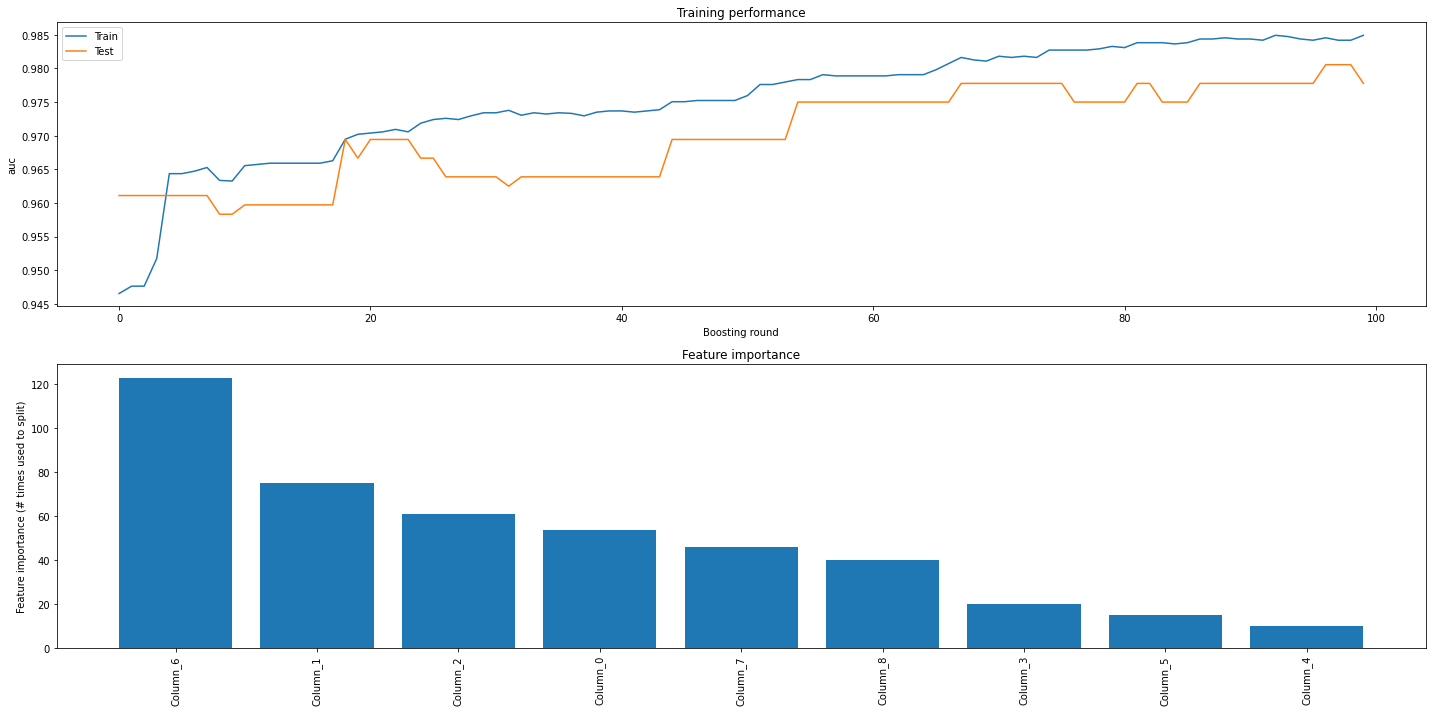

In [11]:
import matplotlib.pyplot as plt
def plot_imp():
    """学習後にtrain,testそれぞれの学習回数ごとのAccuracyグラフと特徴量の重要度のグラフ表示
    """
    fig, axs = plt.subplots(2, 1, figsize=[20, 10])

    # Plot the log loss during training
    axs[0].plot(evaluation_results['Train']['auc'], label='Train')
    axs[0].plot(evaluation_results['Test']['auc'], label='Test')
    axs[0].set_ylabel('auc')
    axs[0].set_xlabel('Boosting round')
    axs[0].set_title('Training performance')
    axs[0].legend()

    # Plot feature importance
    importances = pd.DataFrame({'features': model.feature_name(), 
                                'importance': model.feature_importance()}).sort_values('importance', ascending=False)
    axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
    axs[1].set_xticks(np.arange(len(importances)))
    axs[1].set_xticklabels(importances['features'])
    axs[1].set_ylabel('Feature importance (# times used to split)')
    axs[1].set_title('Feature importance')

    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.show()
    plt.savefig("重要度.png")

plot_imp()

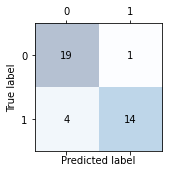

[[19  1]
 [ 4 14]]
[[19  1]
 [ 4 14]]


In [12]:
#混同行列
from sklearn.metrics import confusion_matrix

def confm(route_name,dep,days_ago,y_pred,y_test):
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.savefig('../data/images_conf/'+route_name+'_'+dep+'_'+str(days_ago)+'.png', dpi=300)
    plt.show()
    print(confmat)
    
    return confmat
confmat = confm(route_name,dep,days_ago,y_pred,y_test)
print(confmat)

In [13]:
print(type(y_test))

<class 'pandas.core.series.Series'>


In [14]:
#適合率、再現率、F1スコア
from sklearn.metrics import precision_score, recall_score, f1_score

path_w = "../data/result_value/1_30_value.txt"
with open(path_w, mode='a') as f:
    f.writelines('Accuracy : %.3f\n' % accuracy_score(y_test, y_pred))
    f.writelines('Precision: %.3f\n' % precision_score(y_true=y_test, y_pred=y_pred))
    f.writelines('Recall: %.3f\n' % recall_score(y_true=y_test, y_pred=y_pred))
    f.writelines('F1: %.3f\n' % f1_score(y_true=y_test, y_pred=y_pred))
    f.writelines(str(confmat)+"\n")
    
print(accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
print(confmat)

def result_txt(path_txt,route_name,dep,days_ago,confmat=False,y_test=False, y_pred=False, e=True):
    if e == True:
        with open(path_txt, mode='a') as f:                   #追記"a"
            f.writelines('出発航路'+route_name+' 出発港'+dep+' 日にち '+str(days_ago)+'日前 \n')
            f.writelines("欠航データなし\n")
#             f.writelines('Labels counts in y[0 1]:', np.bincount(y))
#             f.writelines('Labels counts in y_train[0 1]:', np.bincount(y_train))
#             f.writelines('Labels counts in y_test[0 1]:', np.bincount(y_test))

    else:
        with open(path_txt, mode='a') as f:                   #追記"a"
            f.writelines('出発航路'+route_name+' 出発港'+dep+' 日にち '+str(days_ago)+'日前 \n')
#             f.writelines('Labels counts in y[0 1]:', np.bincount(y))
#             f.writelines('Labels counts in y_train[0 1]:', np.bincount(y_train))
#             f.writelines('Labels counts in y_test[0 1]:', np.bincount(y_test))
            f.writelines('Accuracy : %.3f\n' % accuracy_score(y_test, y_pred))
            f.writelines('Precision: %.3f\n' % precision_score(y_true=y_test, y_pred=y_pred))
            f.writelines('Recall: %.3f\n' % recall_score(y_true=y_test, y_pred=y_pred))
            f.writelines('F1: %.3f\n' % f1_score(y_true=y_test, y_pred=y_pred))
            f.writelines(str(confmat)+"\n")

0.868421052631579
Precision: 0.933
Recall: 0.778
F1: 0.848
[[19  1]
 [ 4 14]]


Labels counts in y[0 1]: [93 93]
Labels counts in y_train[0 1]: [74 74]
Labels counts in y_test[0 1]: [19 19]
[LightGBM] [Info] Number of positive: 74, number of negative: 74
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

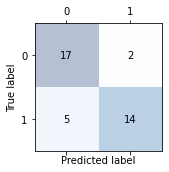

[[17  2]
 [ 5 14]]
No err


In [15]:
import time
import lightgbm as lgb

route_name = "hatoma_route"
dep = "hatoma_dep"
days_ago = 1
path_txt = "../data/result_value/2_5_value.txt"
def main(route_name,dep,days_ago,path_txt):
    X,y,df = df_load(route_name,dep,days_ago)
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1, stratify=y)
        print('Labels counts in y[0 1]:', np.bincount(y))
        print('Labels counts in y_train[0 1]:', np.bincount(y_train))
        print('Labels counts in y_test[0 1]:', np.bincount(y_test))

        #train_data = None
        #train_data = train_data(X_train, y_train,lgb)
        train_data = lgb.Dataset(X_train, label=y_train)
        #time.sleep(2)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
        #test_data = test_data(X_test, y_test, train_data,lgb)

        parameters = par()

        model,evaluation_results = fit(train_data, test_data, parameters, batch=100)

        y_pred_proba = predict(model,X_test)
        y_pred = [0 if i < 0.5 else 1 for i in y_pred_proba]
        y_train_proba = predict(model,X_train)                        #確率表記のpred
        y_pred_train = [0 if i < 0.5 else 1 for i in y_train_proba]   #二値表記に直している
        print(accuracy_score(y_test, y_pred))

        confmat=confm(route_name,dep,days_ago,y_pred,y_test)
        e = False
        result_txt(path_txt,route_name,dep,days_ago,confmat,y_test, y_pred,e)
        print("No err")
    except Exception as e:
        print(e)
        err = True
        result_txt(path_txt,route_name,dep,days_ago,confmat,y_test, y_pred,err)
        
main(route_name,dep,days_ago,path_txt)


taketomi_route isigaki_dep 1
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 2
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 3
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 4
Labels counts in y[0 1]: [979]
Labels counts in y_train[0 1]: [783]
Labels counts in y_test[0 1]: [196]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

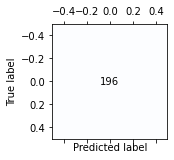

[[196]]
No err
ループ
taketomi_route isigaki_dep 5
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 6
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 7
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 8
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 9
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route taketomi_dep 1
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class canno

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[80]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

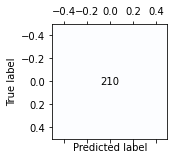

[[210]]
No err
ループ
taketomi_route taketomi_dep 5
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route taketomi_dep 6
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route taketomi_dep 7
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route taketomi_dep 8
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route taketomi_dep 9
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
kurosima_route isigaki_dep 1
Labels counts in y[0 1]: [371   4]
Labels counts in y_train[0 1]: [297   3]
Labels counts in y_test[0 1]: [74  1

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

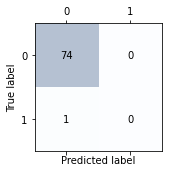

[[74  0]
 [ 1  0]]
No err
ループ
kurosima_route isigaki_dep 2
Labels counts in y[0 1]: [370   4]
Labels counts in y_train[0 1]: [296   3]
Labels counts in y_test[0 1]: [74  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 299, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010033 -> initscore=-4.591747
[LightGBM] [Info] Start training from score -4.591747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 1	Test's auc: 0.864865
[Ligh

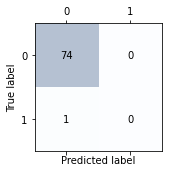

[[74  0]
 [ 1  0]]
No err
ループ
kurosima_route isigaki_dep 3
Labels counts in y[0 1]: [366   4]
Labels counts in y_train[0 1]: [293   3]
Labels counts in y_test[0 1]: [73  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 296, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010135 -> initscore=-4.581560
[LightGBM] [Info] Start training from score -4.581560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.997725	Test's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

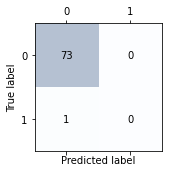

[[73  0]
 [ 1  0]]
No err
ループ
kurosima_route isigaki_dep 4
Labels counts in y[0 1]: [367]
Labels counts in y_train[0 1]: [293]
Labels counts in y_test[0 1]: [74]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [War

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


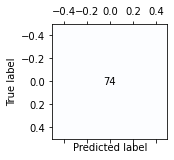

[[74]]
No err
ループ
kurosima_route isigaki_dep 5
Labels counts in y[0 1]: [360   3]
Labels counts in y_train[0 1]: [288   2]
Labels counts in y_test[0 1]: [72  1]
[LightGBM] [Info] Number of positive: 2, number of negative: 288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 290, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006897 -> initscore=-4.969813
[LightGBM] [Info] Start training from score -4.969813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

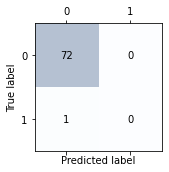

[[72  0]
 [ 1  0]]
No err
ループ
kurosima_route isigaki_dep 6
Labels counts in y[0 1]: [355   4]
Labels counts in y_train[0 1]: [284   3]
Labels counts in y_test[0 1]: [71  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010453 -> initscore=-4.550362
[LightGBM] [Info] Start training from score -4.550362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

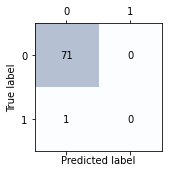

[[71  0]
 [ 1  0]]
No err
ループ
kurosima_route isigaki_dep 7
Labels counts in y[0 1]: [350   4]
Labels counts in y_train[0 1]: [280   3]
Labels counts in y_test[0 1]: [70  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 280
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 283, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010601 -> initscore=-4.536177
[LightGBM] [Info] Start training from score -4.536177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

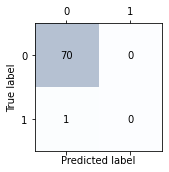

[[70  0]
 [ 1  0]]
No err
ループ
kurosima_route isigaki_dep 8
Labels counts in y[0 1]: [347   3]
Labels counts in y_train[0 1]: [278   2]
Labels counts in y_test[0 1]: [69  1]
[LightGBM] [Info] Number of positive: 2, number of negative: 278
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007143 -> initscore=-4.934474
[LightGBM] [Info] Start training from score -4.934474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

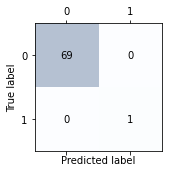

[[69  0]
 [ 0  1]]
No err
ループ
kurosima_route isigaki_dep 9
Labels counts in y[0 1]: [342   4]
Labels counts in y_train[0 1]: [273   3]
Labels counts in y_test[0 1]: [69  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 273
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010870 -> initscore=-4.510860
[LightGBM] [Info] Start training from score -4.510860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

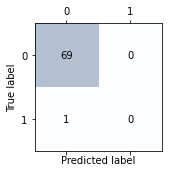

[[69  0]
 [ 1  0]]
No err
ループ
kurosima_route kurosima_dep 1
Labels counts in y[0 1]: [367   4]
Labels counts in y_train[0 1]: [293   3]
Labels counts in y_test[0 1]: [74  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 296, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010135 -> initscore=-4.581560
[LightGBM] [Info] Start training from score -4.581560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

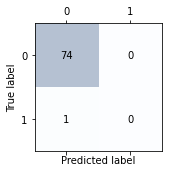

[[74  0]
 [ 1  0]]
No err
ループ
kurosima_route kurosima_dep 2
Labels counts in y[0 1]: [366   4]
Labels counts in y_train[0 1]: [293   3]
Labels counts in y_test[0 1]: [73  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 296, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010135 -> initscore=-4.581560
[LightGBM] [Info] Start training from score -4.581560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 1	Test'

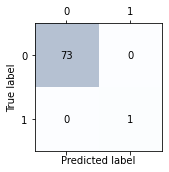

[[73  0]
 [ 0  1]]
No err
ループ
kurosima_route kurosima_dep 3
Labels counts in y[0 1]: [362   4]
Labels counts in y_train[0 1]: [289   3]
Labels counts in y_test[0 1]: [73  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 292, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010274 -> initscore=-4.567814
[LightGBM] [Info] Start training from score -4.567814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

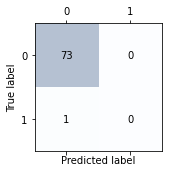

[[73  0]
 [ 1  0]]
No err
ループ
kurosima_route kurosima_dep 4
Labels counts in y[0 1]: [363]
Labels counts in y_train[0 1]: [290]
Labels counts in y_test[0 1]: [73]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 290
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 290, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Wa

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[100]	Train's auc: 1	Test's auc: 1
1.0


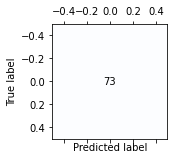

[[73]]
No err
ループ
kurosima_route kurosima_dep 5
Labels counts in y[0 1]: [356   3]
Labels counts in y_train[0 1]: [285   2]
Labels counts in y_test[0 1]: [71  1]
[LightGBM] [Info] Number of positive: 2, number of negative: 285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006969 -> initscore=-4.959342
[LightGBM] [Info] Start training from score -4.959342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

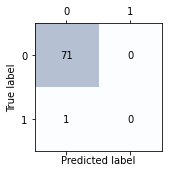

[[71  0]
 [ 1  0]]
No err
ループ
kurosima_route kurosima_dep 6
Labels counts in y[0 1]: [351   4]
Labels counts in y_train[0 1]: [281   3]
Labels counts in y_test[0 1]: [70  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 281
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010563 -> initscore=-4.539742
[LightGBM] [Info] Start training from score -4.539742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 1	Test's auc: 0.0428571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

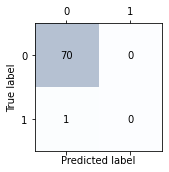

[[70  0]
 [ 1  0]]
No err
ループ
kurosima_route kurosima_dep 7
Labels counts in y[0 1]: [346   4]
Labels counts in y_train[0 1]: [277   3]
Labels counts in y_test[0 1]: [69  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 277
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010714 -> initscore=-4.525405
[LightGBM] [Info] Start training from score -4.525405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 1	Test's auc: 0.927536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

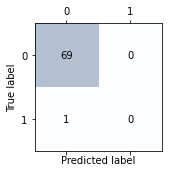

[[69  0]
 [ 1  0]]
No err
ループ
kurosima_route kurosima_dep 8
Labels counts in y[0 1]: [343   3]
Labels counts in y_train[0 1]: [274   2]
Labels counts in y_test[0 1]: [69  1]
[LightGBM] [Info] Number of positive: 2, number of negative: 274
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007246 -> initscore=-4.919981
[LightGBM] [Info] Start training from score -4.919981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

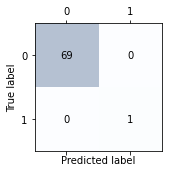

[[69  0]
 [ 0  1]]
No err
ループ
kurosima_route kurosima_dep 9
Labels counts in y[0 1]: [338   4]
Labels counts in y_train[0 1]: [270   3]
Labels counts in y_test[0 1]: [68  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 270
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 273, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010989 -> initscore=-4.499810
[LightGBM] [Info] Start training from score -4.499810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 1	Test's auc: 0.926471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

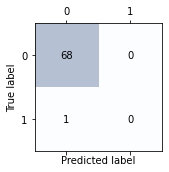

[[68  0]
 [ 1  0]]
No err
ループ
kohama_route isigaki_dep 1
Labels counts in y[0 1]: [536]
Labels counts in y_train[0 1]: [428]
Labels counts in y_test[0 1]: [108]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 428
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warn

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[80]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

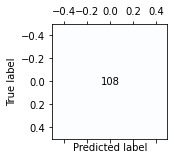

[[108]]
No err
ループ
kohama_route isigaki_dep 2
Labels counts in y[0 1]: [535]
Labels counts in y_train[0 1]: [428]
Labels counts in y_test[0 1]: [107]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 428
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stoppe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[80]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

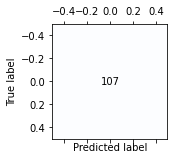

[[107]]
No err
ループ
kohama_route isigaki_dep 3
Labels counts in y[0 1]: [528]
Labels counts in y_train[0 1]: [422]
Labels counts in y_test[0 1]: [106]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 422
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 422, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[100]	Train's auc: 1	Test's auc: 1
1.0


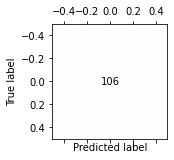

[[106]]
No err
ループ
kohama_route isigaki_dep 4
Labels counts in y[0 1]: [521]
Labels counts in y_train[0 1]: [416]
Labels counts in y_test[0 1]: [105]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 416
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 416, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stoppe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

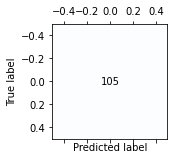

[[105]]
No err
ループ
kohama_route isigaki_dep 5
Labels counts in y[0 1]: [514]
Labels counts in y_train[0 1]: [411]
Labels counts in y_test[0 1]: [103]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 411
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 411, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stoppe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

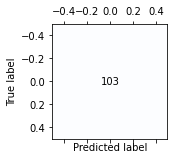

[[103]]
No err
ループ
kohama_route isigaki_dep 6
Labels counts in y[0 1]: [507]
Labels counts in y_train[0 1]: [405]
Labels counts in y_test[0 1]: [102]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 405
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 405, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stoppe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

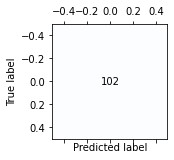

[[102]]
No err
ループ
kohama_route isigaki_dep 7
Labels counts in y[0 1]: [501]
Labels counts in y_train[0 1]: [400]
Labels counts in y_test[0 1]: [101]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stoppe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

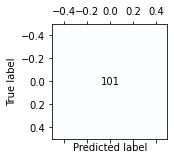

[[101]]
No err
ループ
kohama_route isigaki_dep 8


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Labels counts in y[0 1]: [494]
Labels counts in y_train[0 1]: [395]
Labels counts in y_test[0 1]: [99]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 395
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM]

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more

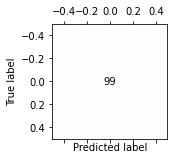

[[99]]
No err
ループ
kohama_route isigaki_dep 9
Labels counts in y[0 1]: [487]
Labels counts in y_train[0 1]: [389]
Labels counts in y_test[0 1]: [98]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 389, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)



[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped tr

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

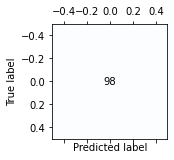

[[98]]
No err
ループ
kohama_route kohama_dep 1
Labels counts in y[0 1]: [604]
Labels counts in y_train[0 1]: [483]
Labels counts in y_test[0 1]: [121]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[LightGBM] [Info] Number of data points in the train set: 483, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leave

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

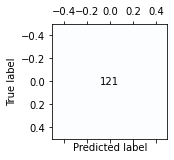

[[121]]
No err
ループ
kohama_route kohama_dep 2
Labels counts in y[0 1]: [603]
Labels counts in y_train[0 1]: [482]
Labels counts in y_test[0 1]: [121]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 482, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[20]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[100]	Train's auc: 1	Test's auc: 1
1.0


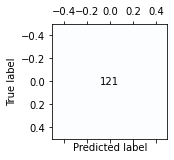

[[121]]
No err
ループ
kohama_route kohama_dep 3
Labels counts in y[0 1]: [596]
Labels counts in y_train[0 1]: [476]
Labels counts in y_test[0 1]: [120]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[40]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

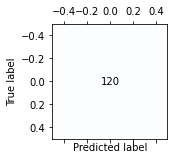

[[120]]
No err
ループ
kohama_route kohama_dep 4


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Labels counts in y[0 1]: [589]
Labels counts in y_train[0 1]: [471]
Labels counts in y_test[0 1]: [118]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves th

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[60]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

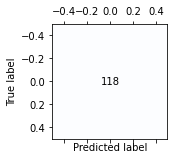

[[118]]
No err
ループ
kohama_route kohama_dep 5
Labels counts in y[0 1]: [582]
Labels counts in y_train[0 1]: [465]
Labels counts in y_test[0 1]: [117]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 465
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 465, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[20]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

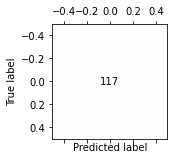

[[117]]
No err
ループ
kohama_route kohama_dep 6
Labels counts in y[0 1]: [575]
Labels counts in y_train[0 1]: [460]
Labels counts in y_test[0 1]: [115]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 460
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

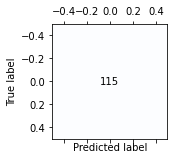

[[115]]
No err
ループ
kohama_route kohama_dep 7
Labels counts in y[0 1]: [569]
Labels counts in y_train[0 1]: [455]
Labels counts in y_test[0 1]: [114]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 455
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[40]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped t

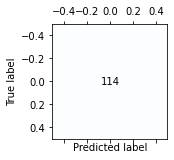

[[114]]
No err
ループ
kohama_route kohama_dep 8
Labels counts in y[0 1]: [562]
Labels counts in y_train[0 1]: [449]
Labels counts in y_test[0 1]: [113]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 449
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

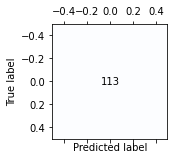

[[113]]
No err
ループ
kohama_route kohama_dep 9
Labels counts in y[0 1]: [555]
Labels counts in y_train[0 1]: [444]
Labels counts in y_test[0 1]: [111]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 444, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

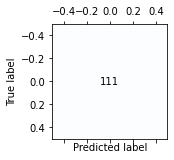

[[111]]
No err
ループ
iriomote_uehara_route isigaki_dep 1
Labels counts in y[0 1]: [340 330]
Labels counts in y_train[0 1]: [272 264]
Labels counts in y_test[0 1]: [68 66]
[LightGBM] [Info] Number of positive: 264, number of negative: 272
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 536, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492537 -> initscore=-0.029853
[LightGBM] [Info] Start training from score -0.029853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

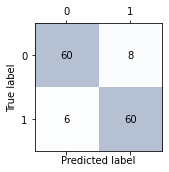

[[60  8]
 [ 6 60]]
No err
ループ
iriomote_uehara_route isigaki_dep 2
Labels counts in y[0 1]: [343 326]
Labels counts in y_train[0 1]: [274 261]
Labels counts in y_test[0 1]: [69 65]
[LightGBM] [Info] Number of positive: 261, number of negative: 274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 535, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487850 -> initscore=-0.048608
[LightGBM] [Info] Start training from score -0.048608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.94843	Test's auc: 0.906577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

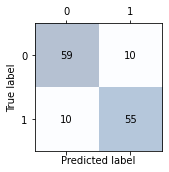

[[59 10]
 [10 55]]
No err
ループ
iriomote_uehara_route isigaki_dep 3
Labels counts in y[0 1]: [335 327]
Labels counts in y_train[0 1]: [268 261]
Labels counts in y_test[0 1]: [67 66]
[LightGBM] [Info] Number of positive: 261, number of negative: 268
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 529, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493384 -> initscore=-0.026467
[LightGBM] [Info] Start training from score -0.026467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.974545	Test's auc: 0.891678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

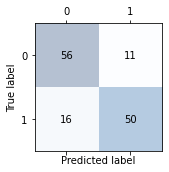

[[56 11]
 [16 50]]
No err
ループ
iriomote_uehara_route isigaki_dep 4
Labels counts in y[0 1]: [340 315]
Labels counts in y_train[0 1]: [272 252]
Labels counts in y_test[0 1]: [68 63]
[LightGBM] [Info] Number of positive: 252, number of negative: 272
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 524, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480916 -> initscore=-0.076373
[LightGBM] [Info] Start training from score -0.076373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.96548

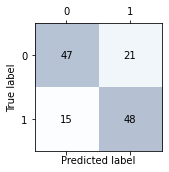

[[47 21]
 [15 48]]
No err
ループ
iriomote_uehara_route isigaki_dep 5
Labels counts in y[0 1]: [335 313]
Labels counts in y_train[0 1]: [268 250]
Labels counts in y_test[0 1]: [67 63]
[LightGBM] [Info] Number of positive: 250, number of negative: 268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 518, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482625 -> initscore=-0.069526
[LightGBM] [Info] Start training from score -0.069526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

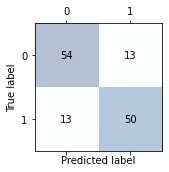

[[54 13]
 [13 50]]
No err
ループ
iriomote_uehara_route isigaki_dep 6
Labels counts in y[0 1]: [336 305]
Labels counts in y_train[0 1]: [268 244]
Labels counts in y_test[0 1]: [68 61]
[LightGBM] [Info] Number of positive: 244, number of negative: 268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476562 -> initscore=-0.093819
[LightGBM] [Info] Start training from score -0.093819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.959345	Test's auc: 0.833293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

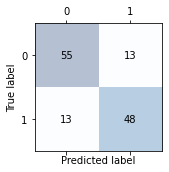

[[55 13]
 [13 48]]
No err
ループ
iriomote_uehara_route isigaki_dep 7
Labels counts in y[0 1]: [328 307]
Labels counts in y_train[0 1]: [262 246]
Labels counts in y_test[0 1]: [66 61]
[LightGBM] [Info] Number of positive: 246, number of negative: 262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484252 -> initscore=-0.063013
[LightGBM] [Info] Start training from score -0.063013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

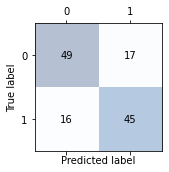

[[49 17]
 [16 45]]
No err
ループ
iriomote_uehara_route isigaki_dep 8
Labels counts in y[0 1]: [309 319]
Labels counts in y_train[0 1]: [247 255]
Labels counts in y_test[0 1]: [62 64]
[LightGBM] [Info] Number of positive: 255, number of negative: 247
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 502, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507968 -> initscore=0.031875
[LightGBM] [Info] Start training from score 0.031875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

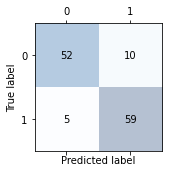

[[52 10]
 [ 5 59]]
No err
ループ
iriomote_uehara_route isigaki_dep 9
Labels counts in y[0 1]: [317 304]
Labels counts in y_train[0 1]: [253 243]
Labels counts in y_test[0 1]: [64 61]
[LightGBM] [Info] Number of positive: 243, number of negative: 253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 496, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489919 -> initscore=-0.040328
[LightGBM] [Info] Start training from score -0.040328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.945551	Test's auc: 0.894467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

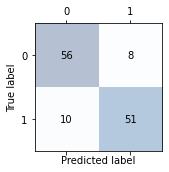

[[56  8]
 [10 51]]
No err
ループ
iriomote_uehara_route uehara_dep 1
Labels counts in y[0 1]: [337 331]
Labels counts in y_train[0 1]: [269 265]
Labels counts in y_test[0 1]: [68 66]
[LightGBM] [Info] Number of positive: 265, number of negative: 269
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496255 -> initscore=-0.014982
[LightGBM] [Info] Start training from score -0.014982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

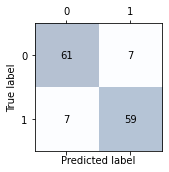

[[61  7]
 [ 7 59]]
No err
ループ
iriomote_uehara_route uehara_dep 2
Labels counts in y[0 1]: [342 325]
Labels counts in y_train[0 1]: [273 260]
Labels counts in y_test[0 1]: [69 65]
[LightGBM] [Info] Number of positive: 260, number of negative: 273
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487805 -> initscore=-0.048790
[LightGBM] [Info] Start training from score -0.048790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.961961	Test's auc: 0.915273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

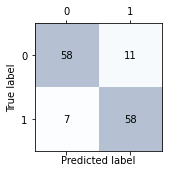

[[58 11]
 [ 7 58]]
No err
ループ
iriomote_uehara_route uehara_dep 3
Labels counts in y[0 1]: [333 327]
Labels counts in y_train[0 1]: [266 262]
Labels counts in y_test[0 1]: [67 65]
[LightGBM] [Info] Number of positive: 262, number of negative: 266
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496212 -> initscore=-0.015152
[LightGBM] [Info] Start training from score -0.015152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.962894	Test's auc: 0.822732
[LightGBM] [Warning] No further splits with positive

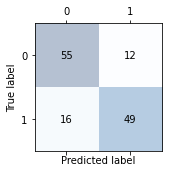

[[55 12]
 [16 49]]
No err
ループ
iriomote_uehara_route uehara_dep 4
Labels counts in y[0 1]: [338 316]
Labels counts in y_train[0 1]: [270 253]
Labels counts in y_test[0 1]: [68 63]
[LightGBM] [Info] Number of positive: 253, number of negative: 270
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 523, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483748 -> initscore=-0.065032
[LightGBM] [Info] Start training from score -0.065032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.961045	Test's auc: 0.861111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

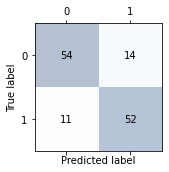

[[54 14]
 [11 52]]
No err
ループ
iriomote_uehara_route uehara_dep 5
Labels counts in y[0 1]: [330 317]
Labels counts in y_train[0 1]: [264 253]
Labels counts in y_test[0 1]: [66 64]
[LightGBM] [Info] Number of positive: 253, number of negative: 264
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 517, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489362 -> initscore=-0.042560
[LightGBM] [Info] Start training from score -0.042560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.956986	Test's auc: 0.885772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

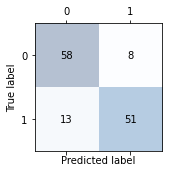

[[58  8]
 [13 51]]
No err
ループ
iriomote_uehara_route uehara_dep 6
Labels counts in y[0 1]: [332 308]
Labels counts in y_train[0 1]: [266 246]
Labels counts in y_test[0 1]: [66 62]
[LightGBM] [Info] Number of positive: 246, number of negative: 266
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 453
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480469 -> initscore=-0.078165
[LightGBM] [Info] Start training from score -0.078165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.971315	Test's auc: 0.842864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

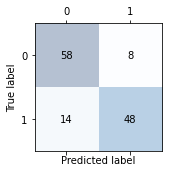

[[58  8]
 [14 48]]
No err
ループ
iriomote_uehara_route uehara_dep 7
Labels counts in y[0 1]: [326 307]
Labels counts in y_train[0 1]: [261 245]
Labels counts in y_test[0 1]: [65 62]
[LightGBM] [Info] Number of positive: 245, number of negative: 261
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 506, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484190 -> initscore=-0.063262
[LightGBM] [Info] Start training from score -0.063262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

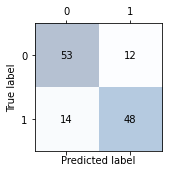

[[53 12]
 [14 48]]
No err
ループ
iriomote_uehara_route uehara_dep 8
Labels counts in y[0 1]: [309 317]
Labels counts in y_train[0 1]: [247 253]
Labels counts in y_test[0 1]: [62 64]
[LightGBM] [Info] Number of positive: 253, number of negative: 247
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506000 -> initscore=0.024001
[LightGBM] [Info] Start training from score 0.024001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.955746	Test's auc: 0.897429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

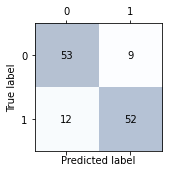

[[53  9]
 [12 52]]
No err
ループ
iriomote_uehara_route uehara_dep 9
Labels counts in y[0 1]: [317 302]
Labels counts in y_train[0 1]: [253 242]
Labels counts in y_test[0 1]: [64 60]
[LightGBM] [Info] Number of positive: 242, number of negative: 253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488889 -> initscore=-0.044452
[LightGBM] [Info] Start training from score -0.044452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.960344	Test's auc: 0.894792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

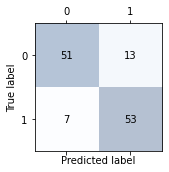

[[51 13]
 [ 7 53]]
No err
ループ
hatoma_route isigaki_dep 1
Labels counts in y[0 1]: [97 93]
Labels counts in y_train[0 1]: [78 74]
Labels counts in y_test[0 1]: [19 19]
[LightGBM] [Info] Number of positive: 74, number of negative: 78
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486842 -> initscore=-0.052644
[LightGBM] [Info] Start training from score -0.052644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

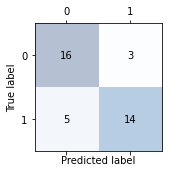

[[16  3]
 [ 5 14]]
No err
ループ
hatoma_route isigaki_dep 2
Labels counts in y[0 1]: [96 94]
Labels counts in y_train[0 1]: [77 75]
Labels counts in y_test[0 1]: [19 19]
[LightGBM] [Info] Number of positive: 75, number of negative: 77
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493421 -> initscore=-0.026317
[LightGBM] [Info] Start training from score -0.026317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.894372	Test's auc: 0.682825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

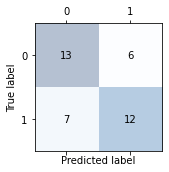

[[13  6]
 [ 7 12]]
No err
ループ
hatoma_route isigaki_dep 3
Labels counts in y[0 1]: [95 93]
Labels counts in y_train[0 1]: [76 74]
Labels counts in y_test[0 1]: [19 19]
[LightGBM] [Info] Number of positive: 74, number of negative: 76
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493333 -> initscore=-0.026668
[LightGBM] [Info] Start training from score -0.026668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.83081

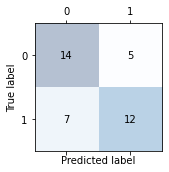

[[14  5]
 [ 7 12]]
No err
ループ
hatoma_route isigaki_dep 4
Labels counts in y[0 1]: [97 89]
Labels counts in y_train[0 1]: [77 71]
Labels counts in y_test[0 1]: [20 18]
[LightGBM] [Info] Number of positive: 71, number of negative: 77
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479730 -> initscore=-0.081126
[LightGBM] [Info] Start training from score -0.081126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.857326	Test's auc: 0.7625
[LightGBM] [Warning] No further splits with positive g

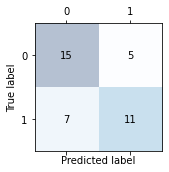

[[15  5]
 [ 7 11]]
No err
ループ
hatoma_route isigaki_dep 5
Labels counts in y[0 1]: [96 88]
Labels counts in y_train[0 1]: [77 70]
Labels counts in y_test[0 1]: [19 18]
[LightGBM] [Info] Number of positive: 70, number of negative: 77
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476190 -> initscore=-0.095310
[LightGBM] [Info] Start training from score -0.095310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.903803	Test's auc: 0.672515
[LightGBM] [Warning] No further splits with positive

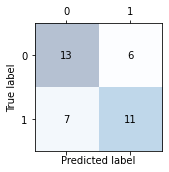

[[13  6]
 [ 7 11]]
No err
ループ
hatoma_route isigaki_dep 6
Labels counts in y[0 1]: [95 87]
Labels counts in y_train[0 1]: [76 69]
Labels counts in y_test[0 1]: [19 18]
[LightGBM] [Info] Number of positive: 69, number of negative: 76
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475862 -> initscore=-0.096627
[LightGBM] [Info] Start training from score -0.096627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.889397	Test's auc: 0.663743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

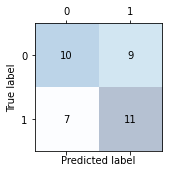

[[10  9]
 [ 7 11]]
No err
ループ
hatoma_route isigaki_dep 7
Labels counts in y[0 1]: [94 87]
Labels counts in y_train[0 1]: [75 69]
Labels counts in y_test[0 1]: [19 18]
[LightGBM] [Info] Number of positive: 69, number of negative: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479167 -> initscore=-0.083382
[LightGBM] [Info] Start training from score -0.083382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

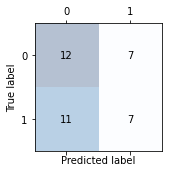

[[12  7]
 [11  7]]
No err
ループ
hatoma_route isigaki_dep 8
Labels counts in y[0 1]: [88 91]
Labels counts in y_train[0 1]: [70 73]
Labels counts in y_test[0 1]: [18 18]
[LightGBM] [Info] Number of positive: 73, number of negative: 70
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510490 -> initscore=0.041964
[LightGBM] [Info] Start training from score 0.041964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.852153	Test's auc: 0.776235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

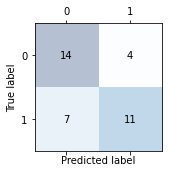

[[14  4]
 [ 7 11]]
No err
ループ
hatoma_route isigaki_dep 9
Labels counts in y[0 1]: [92 85]
Labels counts in y_train[0 1]: [73 68]
Labels counts in y_test[0 1]: [19 17]
[LightGBM] [Info] Number of positive: 68, number of negative: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482270 -> initscore=-0.070952
[LightGBM] [Info] Start training from score -0.070952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.869762	Test's auc: 0.657895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

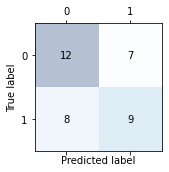

[[12  7]
 [ 8  9]]
No err
ループ
hatoma_route hatoma_dep 1
Labels counts in y[0 1]: [93 93]
Labels counts in y_train[0 1]: [74 74]
Labels counts in y_test[0 1]: [19 19]
[LightGBM] [Info] Number of positive: 74, number of negative: 74
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.927502	Test's auc: 0.862881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

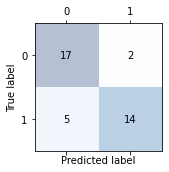

[[17  2]
 [ 5 14]]
No err
ループ
hatoma_route hatoma_dep 2
Labels counts in y[0 1]: [94 92]
Labels counts in y_train[0 1]: [75 73]
Labels counts in y_test[0 1]: [19 19]
[LightGBM] [Info] Number of positive: 73, number of negative: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493243 -> initscore=-0.027029
[LightGBM] [Info] Start training from score -0.027029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.88063

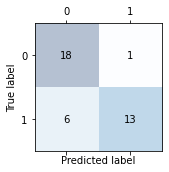

[[18  1]
 [ 6 13]]
No err
ループ
hatoma_route hatoma_dep 3
Labels counts in y[0 1]: [90 94]
Labels counts in y_train[0 1]: [72 75]
Labels counts in y_test[0 1]: [18 19]
[LightGBM] [Info] Number of positive: 75, number of negative: 72
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510204 -> initscore=0.040822
[LightGBM] [Info] Start training from score 0.040822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

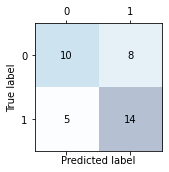

[[10  8]
 [ 5 14]]
No err
ループ
hatoma_route hatoma_dep 4
Labels counts in y[0 1]: [92 90]
Labels counts in y_train[0 1]: [73 72]
Labels counts in y_test[0 1]: [19 18]
[LightGBM] [Info] Number of positive: 72, number of negative: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496552 -> initscore=-0.013793
[LightGBM] [Info] Start training from score -0.013793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.872907	Test's auc: 0.733918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

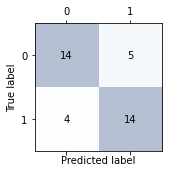

[[14  5]
 [ 4 14]]
No err
ループ
hatoma_route hatoma_dep 5
Labels counts in y[0 1]: [90 90]
Labels counts in y_train[0 1]: [72 72]
Labels counts in y_test[0 1]: [18 18]
[LightGBM] [Info] Number of positive: 72, number of negative: 72
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

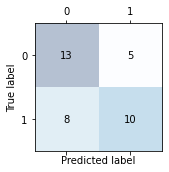

[[13  5]
 [ 8 10]]
No err
ループ
hatoma_route hatoma_dep 6
Labels counts in y[0 1]: [91 87]
Labels counts in y_train[0 1]: [73 69]
Labels counts in y_test[0 1]: [18 18]
[LightGBM] [Info] Number of positive: 69, number of negative: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485915 -> initscore=-0.056353
[LightGBM] [Info] Start training from score -0.056353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.833234	Test's auc: 0.808642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

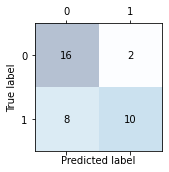

[[16  2]
 [ 8 10]]
No err
ループ
hatoma_route hatoma_dep 7
Labels counts in y[0 1]: [91 86]
Labels counts in y_train[0 1]: [72 69]
Labels counts in y_test[0 1]: [19 17]
[LightGBM] [Info] Number of positive: 69, number of negative: 72
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489362 -> initscore=-0.042560
[LightGBM] [Info] Start training from score -0.042560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

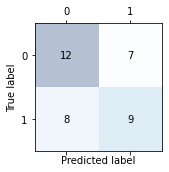

[[12  7]
 [ 8  9]]
No err
ループ
hatoma_route hatoma_dep 8
Labels counts in y[0 1]: [88 87]
Labels counts in y_train[0 1]: [70 70]
Labels counts in y_test[0 1]: [18 17]
[LightGBM] [Info] Number of positive: 70, number of negative: 70
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.884898	Test's auc: 0.751634
[LightGBM] [Warning] No further splits with positive

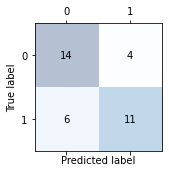

[[14  4]
 [ 6 11]]
No err
ループ
hatoma_route hatoma_dep 9
Labels counts in y[0 1]: [89 84]
Labels counts in y_train[0 1]: [71 67]
Labels counts in y_test[0 1]: [18 17]
[LightGBM] [Info] Number of positive: 67, number of negative: 71
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485507 -> initscore=-0.057987
[LightGBM] [Info] Start training from score -0.057987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.877444	Test's auc: 0.715686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

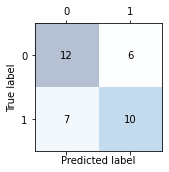

[[12  6]
 [ 7 10]]
No err
ループ
iriomote_ohara_route isigaki_dep 1
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 2
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 3
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 4
Labels counts in y[0 1]: [647]
Labels counts in y_train[0 1]: [517]
Labels counts in y_test[0 1]: [130]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 517
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[Lig

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[80]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

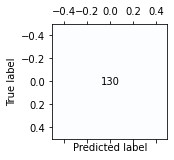

[[130]]
No err
ループ
iriomote_ohara_route isigaki_dep 5
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 6
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 7
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 8
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route isigaki_dep 9
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route ohara_dep 1
The least populated class in y has only 1 member, which is too few. The minimum num

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[40]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

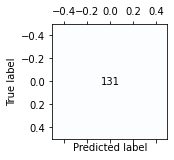

[[131]]
No err
ループ
iriomote_ohara_route ohara_dep 5
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route ohara_dep 6
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route ohara_dep 7
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route ohara_dep 8
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
iriomote_ohara_route ohara_dep 9
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
hateruma_route isigaki_dep 1
Labels counts in y[0 1]: [214  65]
Labels counts in y_train[0 1]: [171  52]
Labels counts in y_te

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

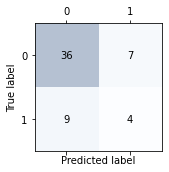

[[36  7]
 [ 9  4]]
No err
ループ
hateruma_route isigaki_dep 2
Labels counts in y[0 1]: [217  61]
Labels counts in y_train[0 1]: [173  49]
Labels counts in y_test[0 1]: [44 12]
[LightGBM] [Info] Number of positive: 49, number of negative: 173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220721 -> initscore=-1.261471
[LightGBM] [Info] Start training from score -1.261471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

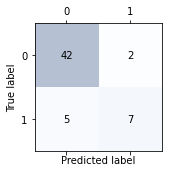

[[42  2]
 [ 5  7]]
No err
ループ
hateruma_route isigaki_dep 3
Labels counts in y[0 1]: [214  61]
Labels counts in y_train[0 1]: [171  49]
Labels counts in y_test[0 1]: [43 12]
[LightGBM] [Info] Number of positive: 49, number of negative: 171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222727 -> initscore=-1.249843
[LightGBM] [Info] Start training from score -1.249843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.922843	Test's auc: 0.74031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

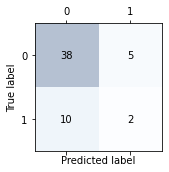

[[38  5]
 [10  2]]
No err
ループ
hateruma_route isigaki_dep 4
Labels counts in y[0 1]: [218  55]
Labels counts in y_train[0 1]: [174  44]
Labels counts in y_test[0 1]: [44 11]
[LightGBM] [Info] Number of positive: 44, number of negative: 174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 218, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201835 -> initscore=-1.374866
[LightGBM] [Info] Start training from score -1.374866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.929075	Test's auc: 0.770661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

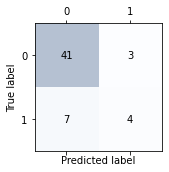

[[41  3]
 [ 7  4]]
No err
ループ
hateruma_route isigaki_dep 5
Labels counts in y[0 1]: [216  54]
Labels counts in y_train[0 1]: [173  43]
Labels counts in y_test[0 1]: [43 11]
[LightGBM] [Info] Number of positive: 43, number of negative: 173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199074 -> initscore=-1.392091
[LightGBM] [Info] Start training from score -1.392091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

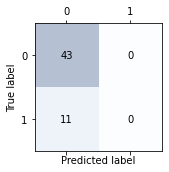

[[43  0]
 [11  0]]
No err
ループ
hateruma_route isigaki_dep 6
Labels counts in y[0 1]: [210  57]
Labels counts in y_train[0 1]: [168  45]
Labels counts in y_test[0 1]: [42 12]
[LightGBM] [Info] Number of positive: 45, number of negative: 168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 213, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211268 -> initscore=-1.317301
[LightGBM] [Info] Start training from score -1.317301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.91005

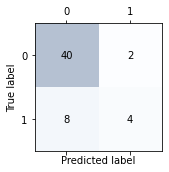

[[40  2]
 [ 8  4]]
No err
ループ
hateruma_route isigaki_dep 7
Labels counts in y[0 1]: [204  60]
Labels counts in y_train[0 1]: [163  48]
Labels counts in y_test[0 1]: [41 12]
[LightGBM] [Info] Number of positive: 48, number of negative: 163
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227488 -> initscore=-1.222549
[LightGBM] [Info] Start training from score -1.222549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.915708	Test's auc: 0.668699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

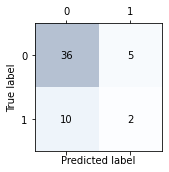

[[36  5]
 [10  2]]
No err
ループ
hateruma_route isigaki_dep 8
Labels counts in y[0 1]: [198  63]
Labels counts in y_train[0 1]: [158  50]
Labels counts in y_test[0 1]: [40 13]
[LightGBM] [Info] Number of positive: 50, number of negative: 158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 208, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240385 -> initscore=-1.150572
[LightGBM] [Info] Start training from score -1.150572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.960506	Test's auc: 0.721154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

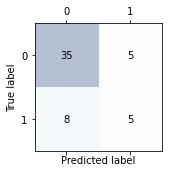

[[35  5]
 [ 8  5]]
No err
ループ
hateruma_route isigaki_dep 9
Labels counts in y[0 1]: [199  59]
Labels counts in y_train[0 1]: [159  47]
Labels counts in y_test[0 1]: [40 12]
[LightGBM] [Info] Number of positive: 47, number of negative: 159
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 206, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228155 -> initscore=-1.218757
[LightGBM] [Info] Start training from score -1.218757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.929479	Test's auc: 0.777083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

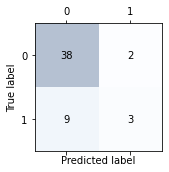

[[38  2]
 [ 9  3]]
No err
ループ
hateruma_route hateruma_dep 1
Labels counts in y[0 1]: [207  63]
Labels counts in y_train[0 1]: [166  50]
Labels counts in y_test[0 1]: [41 13]
[LightGBM] [Info] Number of positive: 50, number of negative: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231481 -> initscore=-1.199965
[LightGBM] [Info] Start training from score -1.199965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	Train's auc: 0.938795	Test's auc: 0.757974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

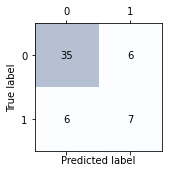

[[35  6]
 [ 6  7]]
No err
ループ
hateruma_route hateruma_dep 2
Labels counts in y[0 1]: [208  61]
Labels counts in y_train[0 1]: [166  49]
Labels counts in y_test[0 1]: [42 12]
[LightGBM] [Info] Number of positive: 49, number of negative: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227907 -> initscore=-1.220167
[LightGBM] [Info] Start training from score -1.220167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

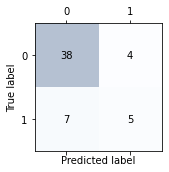

[[38  4]
 [ 7  5]]
No err
ループ
hateruma_route hateruma_dep 3
Labels counts in y[0 1]: [204  62]
Labels counts in y_train[0 1]: [163  49]
Labels counts in y_test[0 1]: [41 13]
[LightGBM] [Info] Number of positive: 49, number of negative: 163
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231132 -> initscore=-1.201930
[LightGBM] [Info] Start training from score -1.201930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.96344

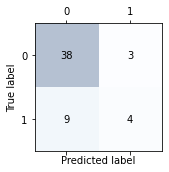

[[38  3]
 [ 9  4]]
No err
ループ
hateruma_route hateruma_dep 4
Labels counts in y[0 1]: [208  55]
Labels counts in y_train[0 1]: [166  44]
Labels counts in y_test[0 1]: [42 11]
[LightGBM] [Info] Number of positive: 44, number of negative: 166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209524 -> initscore=-1.327798
[LightGBM] [Info] Start training from score -1.327798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

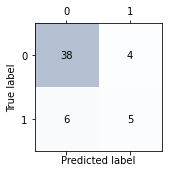

[[38  4]
 [ 6  5]]
No err
ループ
hateruma_route hateruma_dep 5
Labels counts in y[0 1]: [207  54]
Labels counts in y_train[0 1]: [165  43]
Labels counts in y_test[0 1]: [42 11]
[LightGBM] [Info] Number of positive: 43, number of negative: 165
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 208, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206731 -> initscore=-1.344745
[LightGBM] [Info] Start training from score -1.344745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.875053	Test's auc: 0.87987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

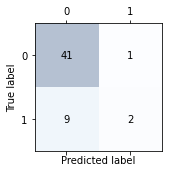

[[41  1]
 [ 9  2]]
No err
ループ
hateruma_route hateruma_dep 6
Labels counts in y[0 1]: [202  56]
Labels counts in y_train[0 1]: [161  45]
Labels counts in y_test[0 1]: [41 11]
[LightGBM] [Info] Number of positive: 45, number of negative: 161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 206, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218447 -> initscore=-1.274742
[LightGBM] [Info] Start training from score -1.274742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.917046	Test's auc: 0.829268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

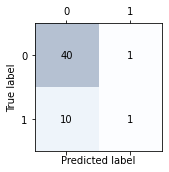

[[40  1]
 [10  1]]
No err
ループ
hateruma_route hateruma_dep 7
Labels counts in y[0 1]: [198  58]
Labels counts in y_train[0 1]: [158  46]
Labels counts in y_test[0 1]: [40 12]
[LightGBM] [Info] Number of positive: 46, number of negative: 158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225490 -> initscore=-1.233954
[LightGBM] [Info] Start training from score -1.233954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.896877	Test's auc: 0.666667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

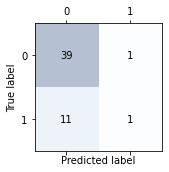

[[39  1]
 [11  1]]
No err
ループ
hateruma_route hateruma_dep 8
Labels counts in y[0 1]: [195  58]
Labels counts in y_train[0 1]: [156  46]
Labels counts in y_test[0 1]: [39 12]
[LightGBM] [Info] Number of positive: 46, number of negative: 156
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 202, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227723 -> initscore=-1.221215
[LightGBM] [Info] Start training from score -1.221215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

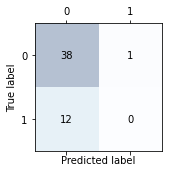

[[38  1]
 [12  0]]
No err
ループ
hateruma_route hateruma_dep 9
Labels counts in y[0 1]: [195  55]
Labels counts in y_train[0 1]: [156  44]
Labels counts in y_test[0 1]: [39 11]
[LightGBM] [Info] Number of positive: 44, number of negative: 156
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220000 -> initscore=-1.265666
[LightGBM] [Info] Start training from score -1.265666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's auc: 0.933275	Test's auc: 0.715618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

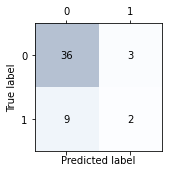

[[36  3]
 [ 9  2]]
No err
ループ


In [55]:
##ここを回せば実行できる
eng_name_dic = {
    "taketomi_route" : ["isigaki_dep", "taketomi_dep"],
    "kurosima_route" : ["isigaki_dep", "kurosima_dep"],
    "kohama_route" : ["isigaki_dep", "kohama_dep"],
    "iriomote_uehara_route" : ["isigaki_dep", "uehara_dep"],
    "hatoma_route" : ["isigaki_dep", "hatoma_dep"],
    "iriomote_ohara_route" : ["isigaki_dep", "ohara_dep"],
   "hateruma_route" : ["isigaki_dep", "hateruma_dep"]
                                           } 
path_txt = "../data/result_value/2_5_value.txt"

for route_name,deps in eng_name_dic.items():
    for dep in deps:
        for days_ago in range(1,10):
        #days_ago=i
            path_txt = "../data/result_value/2_5_value_"+route_name+"_"+dep+".txt"

            try:
                print(route_name,dep,str(days_ago))
                main(route_name,dep,days_ago,path_txt)
            except Exception as e:
                #print(e)
                err = True
                result_txt(path_txt,route_name,dep,days_ago,confmat,y_test, y_pred,err)
            print("ループ")


kurosima_route kurosima_dep 0
Labels counts in y[0 1]: [368   4]
Labels counts in y_train[0 1]: [294   3]
Labels counts in y_test[0 1]: [74  1]
[LightGBM] [Info] Number of positive: 3, number of negative: 294
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 297, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010101 -> initscore=-4.584967
[LightGBM] [Info] Start training from score -4.584967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 1	Test's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

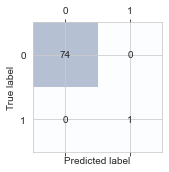

[[74  0]
 [ 0  1]]


In [136]:
route_name = "kurosima_route"
dep = "kurosima_dep"
days_ago = 0
X,y,df = df_load(route_name,dep,days_ago)
print(route_name,dep,str(days_ago))
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=1, stratify=y)
print('Labels counts in y[0 1]:', np.bincount(y))
print('Labels counts in y_train[0 1]:', np.bincount(y_train))
print('Labels counts in y_test[0 1]:', np.bincount(y_test))

#train_data = None
#train_data = train_data(X_train, y_train,lgb)
train_data = lgb.Dataset(X_train, label=y_train)
#time.sleep(2)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
#test_data = test_data(X_test, y_test, train_data,lgb)

parameters = par()

model,evaluation_results = fit(train_data, test_data, parameters, batch=100)

y_pred_proba = predict(model,X_test)
y_pred = [0 if i < 0.5 else 1 for i in y_pred_proba]
y_train_proba = predict(model,X_train)                        #確率表記のpred
y_pred_train = [0 if i < 0.5 else 1 for i in y_train_proba]   #二値表記に直している
print(accuracy_score(y_test, y_pred))

confmat=confm(route_name,dep,days_ago,y_pred,y_test)


In [137]:
print(accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
print(confmat)

1.0
Precision: 1.000
Recall: 1.000
F1: 1.000
[[74  0]
 [ 0  1]]


In [138]:
#print(y_pred)
X_false=pd.DataFrame(None)
X_true=pd.DataFrame(None)
print(X_false)
for index,true,pred,setumei in zip(y_test.index,y_test,y_pred,X_test):
    #print("{}  {} {} {}".format(index,int(true),pred,setumei))
    if int(true) ^ int(pred) == True:
        setumei = np.append(setumei,true)
        setumei = np.append(setumei,pred)
        X_false = pd.concat([X_false, pd.DataFrame(setumei)],axis=1)
        #print(X_false)
        #X_false.append(setumei)
        #print("間違っているよ",int(true) ^ int(pred))
    else:
        setumei = np.append(setumei,true)
        setumei = np.append(setumei,pred)
        X_true = pd.concat([X_true, pd.DataFrame(setumei)],axis=1)
        #print("あたり",int(true) ^ int(pred))

Empty DataFrame
Columns: []
Index: []


In [139]:
X_false = X_false.T
X_ture = X_true.T

X_false["pred"] = 0
X_ture["pred"] = 1
X_test_pred_re = pd.concat([X_ture,X_false])


In [140]:
X_test_pred_re.reset_index(drop=True)
X_test_pred_re.columns = ['max_wind', 'max_wind_dir', 'swell','swell_dir','swell_sp','time','wave_height','wave_he_dir','wind_speed','ture_label','pred_label','pred_True']

In [141]:
X_test_pred_re

,max_wind,max_wind_dir,swell,swell_dir,swell_sp,time,wave_height,wave_he_dir,wind_speed,ture_label,pred_label,pred_True
0,35.0,16.0,1.6,115.0,9.6,18.0,2.6,16.0,24.0,0.0,0.0,1
0,32.0,44.0,1.6,122.0,10.5,17.0,3.3,35.0,24.0,0.0,0.0,1
0,28.0,48.0,1.5,109.0,8.5,18.0,1.9,81.0,19.0,0.0,0.0,1
0,24.0,17.0,1.3,5.0,9.9,12.0,1.8,19.0,14.0,0.0,0.0,1
0,19.0,29.0,1.3,112.0,8.6,9.0,1.7,67.0,13.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
0,20.0,42.0,1.0,106.0,7.3,9.0,1.3,84.0,14.0,0.0,0.0,1
0,12.0,127.0,0.6,93.0,8.3,12.0,0.7,100.0,9.0,0.0,0.0,1
0,30.0,40.0,1.1,351.0,9.0,12.0,1.8,25.0,19.0,0.0,0.0,1
0,14.0,75.0,1.3,110.0,8.1,9.0,1.4,107.0,10.0,0.0,0.0,1


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/

<Figure size 720x360 with 0 Axes>

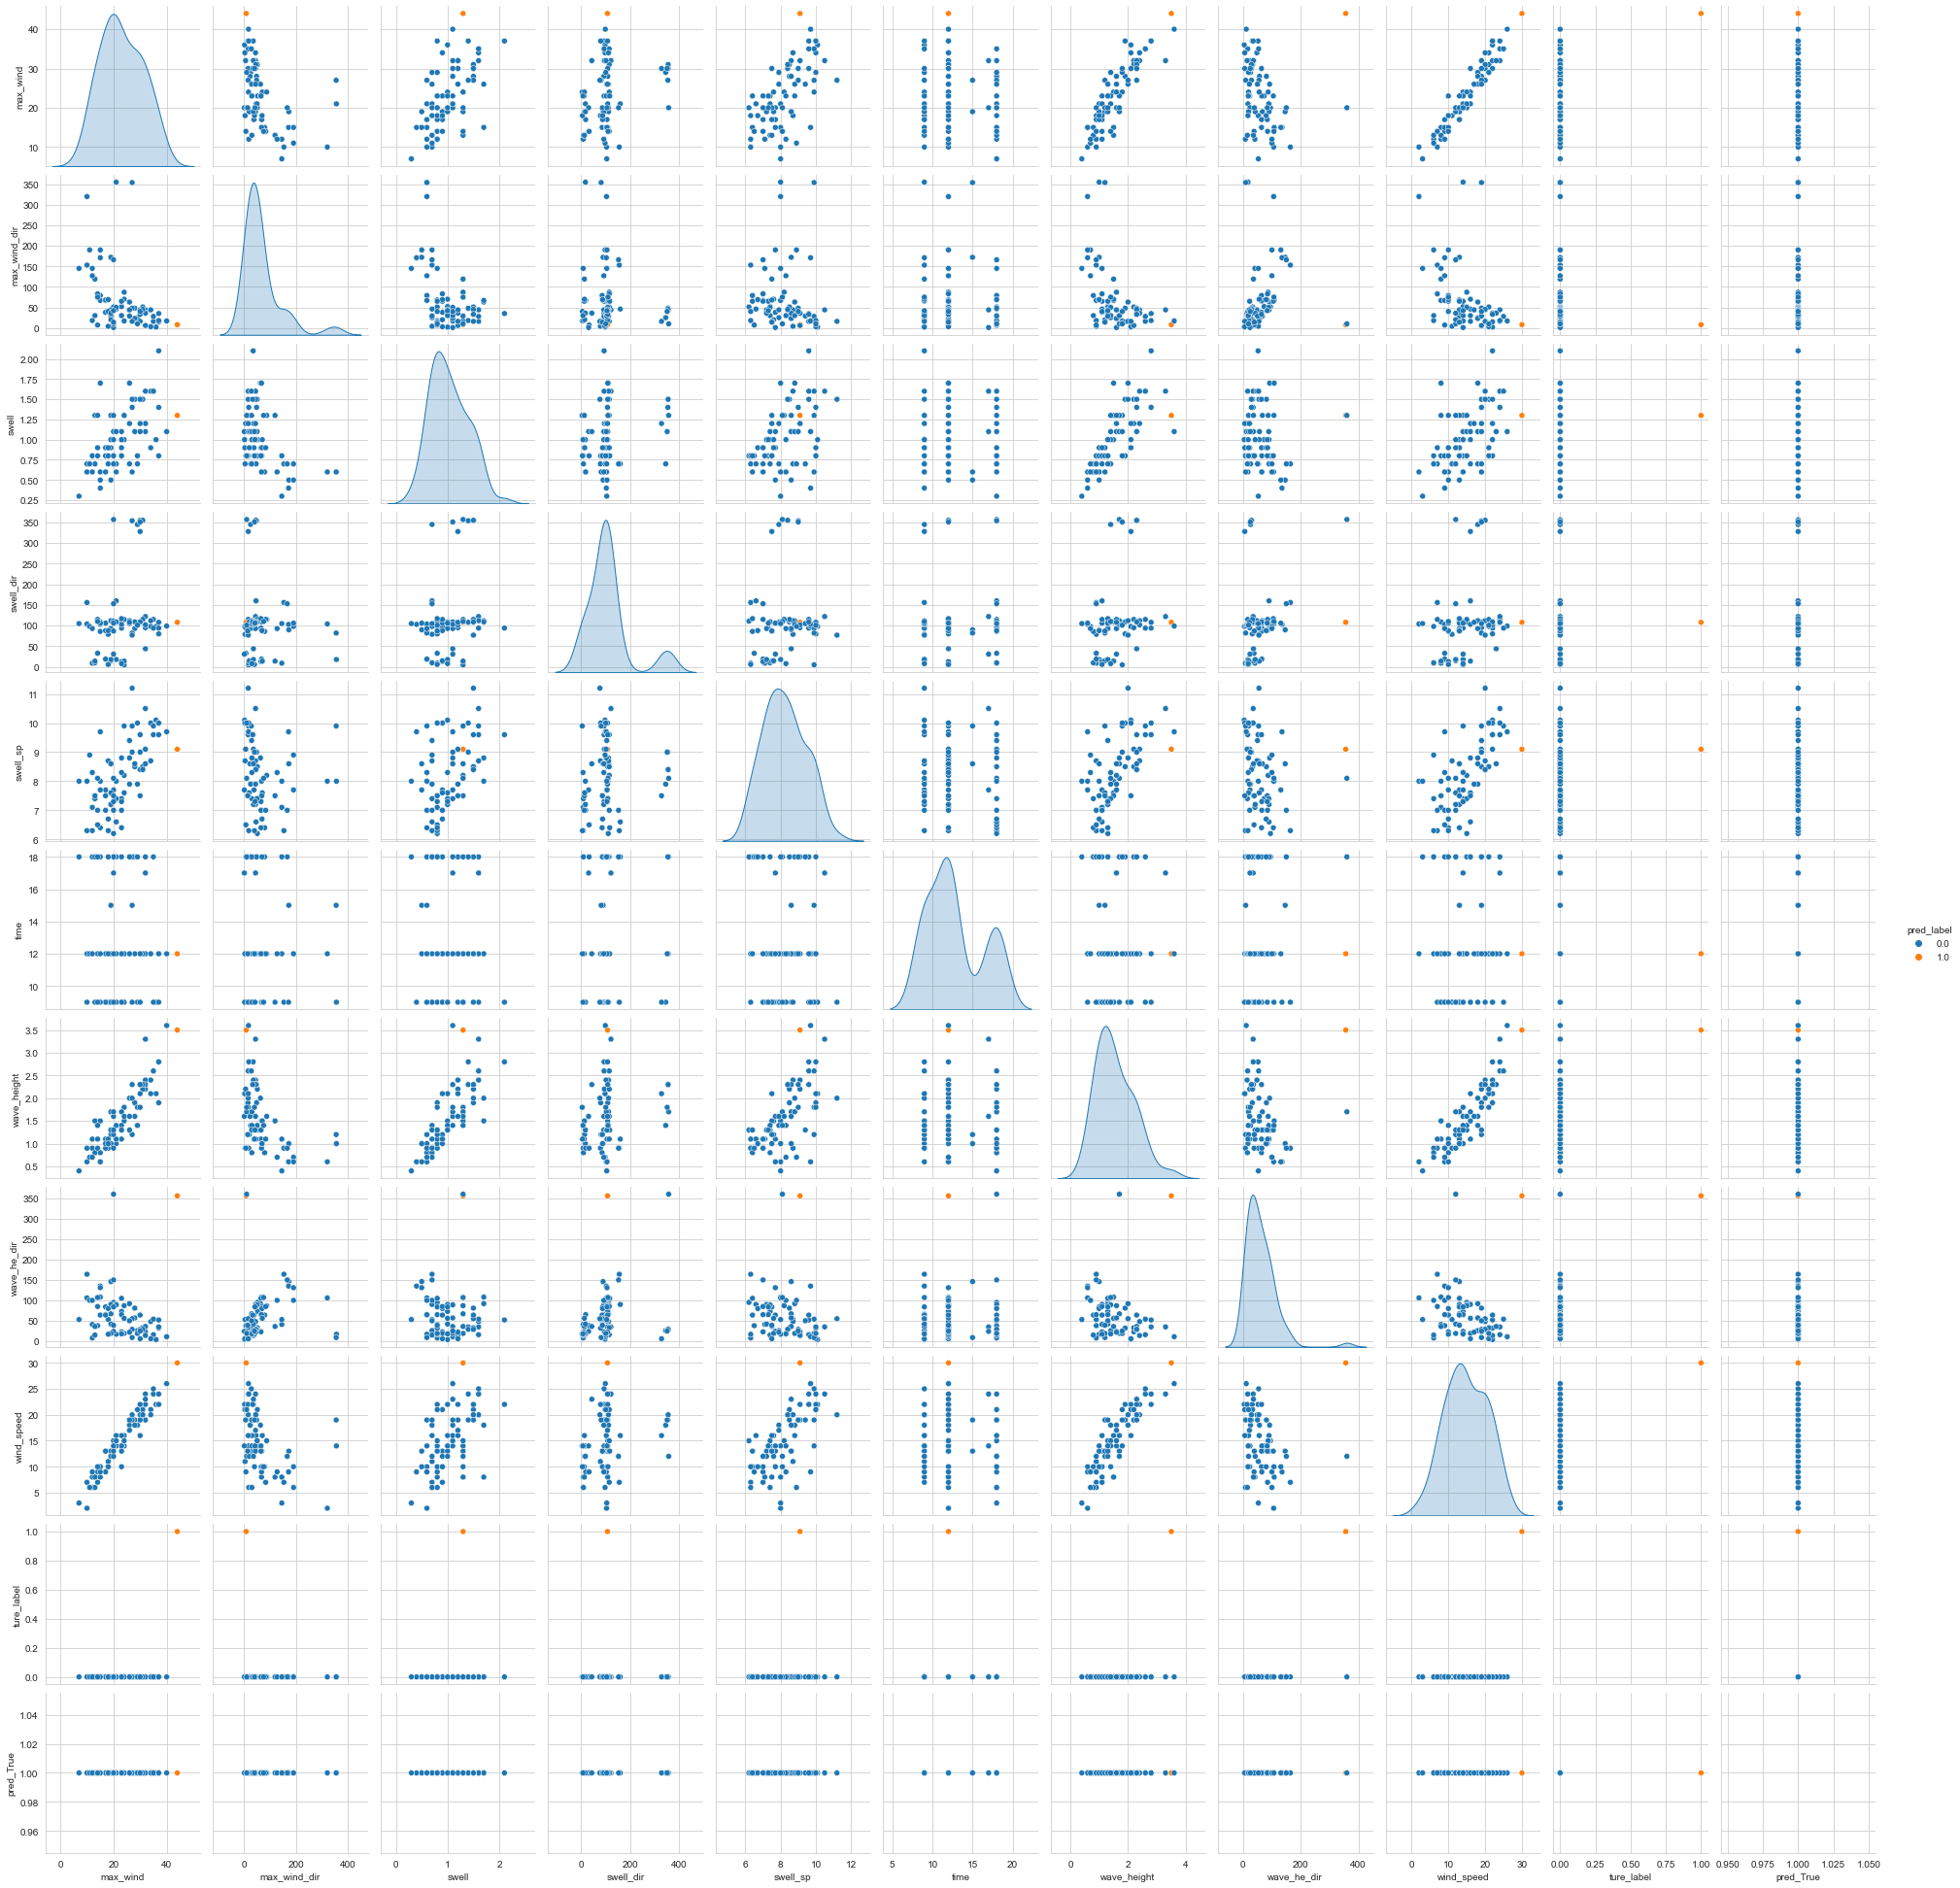

In [142]:
sep_label="pred_label"
plt.figure(figsize=(10,5))
sns.pairplot(X_test_pred_re,hue=sep_label)
plt.grid()
plt.show()

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 720x360 with 0 Axes>

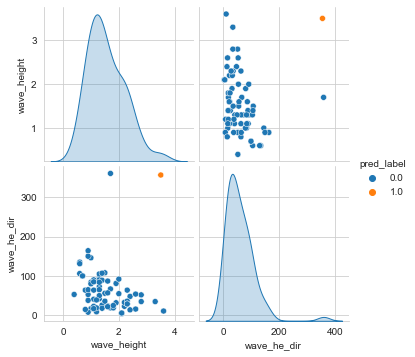

In [144]:
import seaborn as sns
import sys
#見たいラベルの名前
sep_label="pred_label"
plt.figure(figsize=(10,5))
sns.pairplot(X_test_pred_re[["wave_height","wave_he_dir","pred_label"]],hue=sep_label)
plt.grid()
plt.show()
#plt.savefig('../data/analysis/'+route_name+'_'+dep+'_'+str(days_ago)+'_'+sep_label+'.png')

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/

<Figure size 720x360 with 0 Axes>

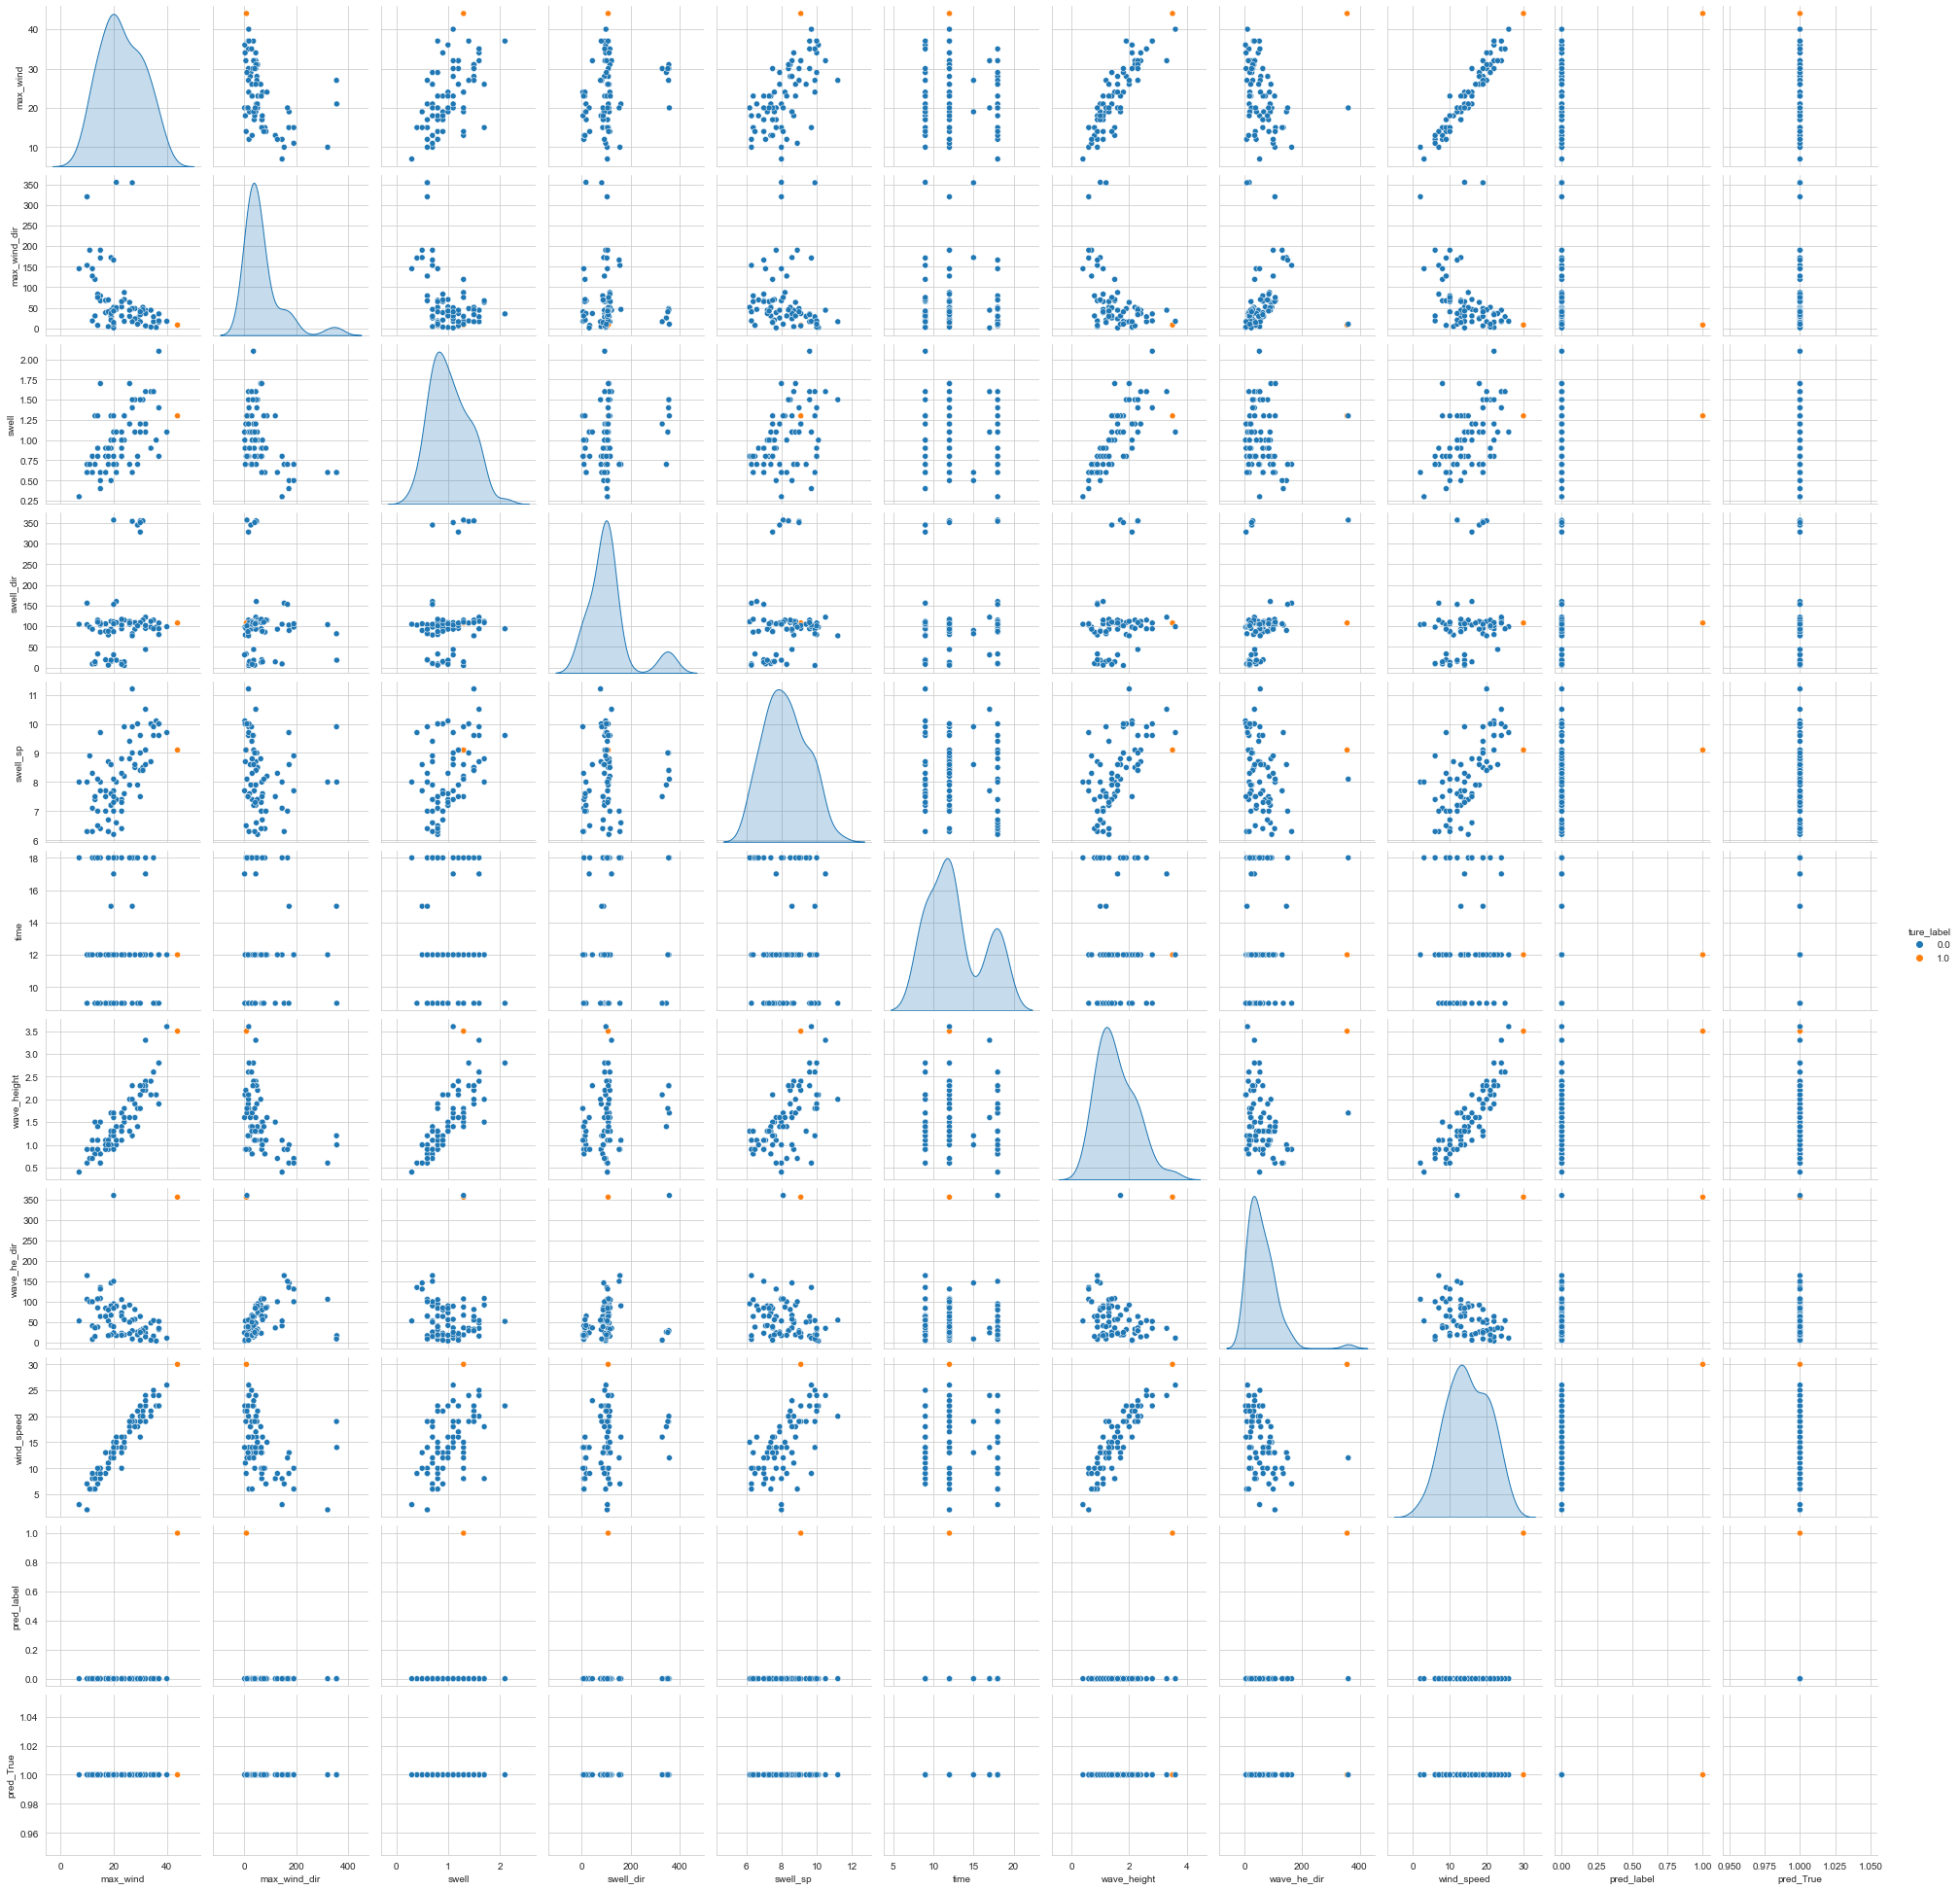

In [143]:
sep_label="ture_label"
plt.figure(figsize=(10,5))
sns.pairplot(X_test_pred_re,hue=sep_label)
plt.grid()
plt.show()

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 720x360 with 0 Axes>

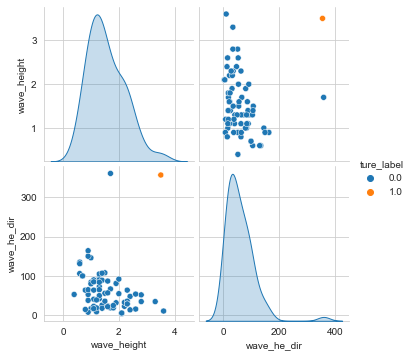

In [145]:
#import seaborn as sns
plt.figure(figsize=(10,5))
sns.pairplot(X_test_pred_re[["wave_height","wave_he_dir","ture_label"]],hue="ture_label")
plt.grid()
plt.show()

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


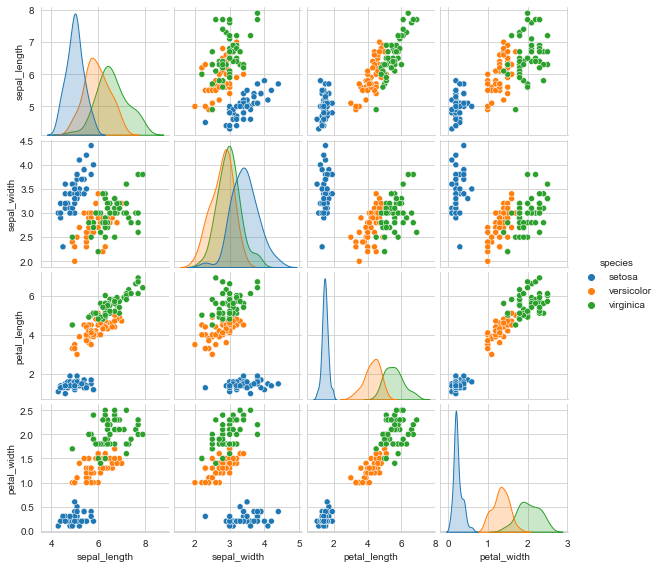

In [25]:
import seaborn as sns

sns.set_style("whitegrid")

iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species", size=2)

In [78]:
print(X_test)

[[3.90e+01 2.50e+01 1.30e+00 1.05e+02 9.20e+00 9.00e+00 2.90e+00 4.00e+01
  2.30e+01]
 [1.10e+01 4.90e+01 5.00e-01 1.03e+02 8.00e+00 9.00e+00 6.00e-01 8.20e+01
  7.00e+00]
 [2.70e+01 4.70e+01 8.00e-01 1.01e+02 9.40e+00 9.00e+00 1.30e+00 4.90e+01
  1.60e+01]
 [1.80e+01 2.10e+01 7.00e-01 5.00e+00 6.60e+00 1.80e+01 1.00e+00 2.50e+01
  9.00e+00]
 [2.50e+01 2.50e+01 1.40e+00 1.00e+01 8.50e+00 9.00e+00 1.60e+00 1.40e+01
  1.10e+01]
 [2.00e+01 1.71e+02 3.00e-01 5.40e+01 1.09e+01 1.20e+01 7.00e-01 1.41e+02
  1.40e+01]
 [1.80e+01 1.67e+02 5.00e-01 9.00e+01 8.70e+00 1.80e+01 1.00e+00 1.48e+02
  1.40e+01]
 [3.20e+01 1.10e+01 1.60e+00 0.00e+00 9.90e+00 9.00e+00 3.30e+00 1.20e+01
  2.10e+01]
 [3.00e+01 2.60e+01 1.20e+00 9.00e+01 7.70e+00 1.80e+01 2.30e+00 1.40e+01
  1.90e+01]
 [1.70e+01 7.80e+01 5.00e-01 1.04e+02 9.20e+00 1.80e+01 7.00e-01 7.90e+01
  1.10e+01]
 [1.50e+01 4.10e+01 7.00e-01 1.01e+02 8.70e+00 1.80e+01 8.00e-01 8.80e+01
  1.10e+01]
 [2.00e+01 5.20e+01 1.60e+00 1.10e+01 7.90e+00 1.80e+0